In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=1), #Input (28, 28, 1) > Output (28, 28, 8)
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.03)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), #Input (28, 28, 8) > Output (28, 28, 16)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03)
        )

        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2,2),  #Input (28, 28, 8) > Output (14, 14, 16)

            nn.Conv2d(16, 16, 3, padding=1),  #Input (14, 14, 8) > Output (14, 14, 16)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),

            nn.Conv2d(16, 8, 3, padding=1), #Input (14, 14, 16) > Output (14, 14, 8)
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.03)
        )

        self.trans2 = nn.Sequential(
            nn.MaxPool2d(2,2), #Input (14, 14, 8) > Output (7, 7, 8)

            nn.Conv2d(8, 16, 3), #Input (7, 7, 8) > Output (5, 5, 16)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),

            nn.Conv2d(16, 16, 3), #Input (5, 5, 16) > Output (3, 3, 16)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),

            nn.Conv2d(16, 16, 1), #Input (3, 3, 16) > Output (3, 3, 10)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),

            nn.Conv2d(16, 10, 1), #Input (3, 3, 16) > Output (3, 3, 10)
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03),

            nn.AvgPool2d(3) #Input (3, 3, 10) > Output (1, 1, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.trans2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [15]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           2,320
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14            [-1, 8,

<ipython-input-14-a36fecf27341>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [16]:
train_transforms = transforms.Compose([transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([ transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [17]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [18]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


torch.Size([64, 1, 28, 28])
torch.Size([64])


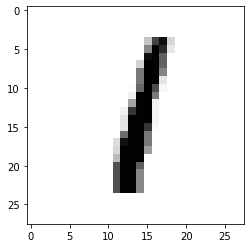

In [19]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[5].numpy().squeeze(), cmap='gray_r')

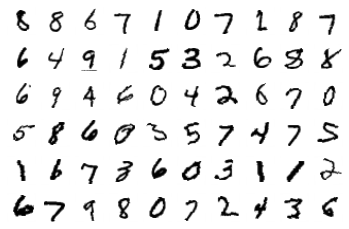

In [20]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [21]:
from tqdm import tqdm

train_losses = []
train_accs = []
test_losses = []
test_accs= []

def train(model, device, train_loader, optimizer, epoch):
    correct_preds = 0
    processed = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Porting the data and targets in to the GPU
        data, target = data.to(device), target.to(device)

        # setting all the gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Loss calculation 
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Back propogation
        loss.backward()

        # Updating the weights with calculated gradients
        optimizer.step()

        # Calculating the correct number of predictions
        preds = output.argmax(dim=1, keepdim=True)
        correct_preds += preds.eq(target.view_as(preds)).sum().item()
        processed += len(data)
        
        # Logging the results using Pbar
        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct_preds/processed:0.2f}')

        # Appending the training accuracies to the train_accs[]
        train_accs.append(100*correct_preds/processed)
        


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Porting the data and targets in to the GPU
            data, target = data.to(device), target.to(device)

            # Predict 
            output = model(data)

            # Test loss calculation
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accs.append(100. * correct / len(test_loader.dataset))

In [22]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15
for epoch in range(0, num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]<ipython-input-14-a36fecf27341>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Epoch=0 Loss=0.15534280240535736 Batch_id=937 Accuracy=92.95: 100%|██████████| 938/938 [01:15<00:00, 12.45it/s]



Test set: Average loss: 0.0755, Accuracy: 9804/10000 (98.04%)



Epoch=1 Loss=0.1568378508090973 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [01:16<00:00, 12.27it/s]



Test set: Average loss: 0.0400, Accuracy: 9895/10000 (98.95%)



Epoch=2 Loss=0.06198321282863617 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [01:14<00:00, 12.53it/s]



Test set: Average loss: 0.0328, Accuracy: 9894/10000 (98.94%)



Epoch=3 Loss=0.019678112119436264 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [01:15<00:00, 12.46it/s]



Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)



Epoch=4 Loss=0.049531400203704834 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [01:14<00:00, 12.60it/s]



Test set: Average loss: 0.0280, Accuracy: 9914/10000 (99.14%)



Epoch=5 Loss=0.2574065029621124 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [01:18<00:00, 12.00it/s]



Test set: Average loss: 0.0219, Accuracy: 9940/10000 (99.40%)



Epoch=6 Loss=0.011770752258598804 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [01:17<00:00, 12.04it/s]



Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)



Epoch=7 Loss=0.03739934042096138 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [01:17<00:00, 12.09it/s]



Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)



Epoch=8 Loss=0.016667358577251434 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [01:16<00:00, 12.24it/s]



Test set: Average loss: 0.0200, Accuracy: 9946/10000 (99.46%)



Epoch=9 Loss=0.004943458829075098 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:16<00:00, 12.27it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)



Epoch=10 Loss=0.10803059488534927 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [01:16<00:00, 12.24it/s]



Test set: Average loss: 0.0191, Accuracy: 9948/10000 (99.48%)



Epoch=11 Loss=0.027243567630648613 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [01:15<00:00, 12.37it/s]



Test set: Average loss: 0.0201, Accuracy: 9947/10000 (99.47%)



Epoch=12 Loss=0.030809050425887108 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:15<00:00, 12.42it/s]



Test set: Average loss: 0.0195, Accuracy: 9948/10000 (99.48%)



Epoch=13 Loss=0.06629624217748642 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]



Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)



Epoch=14 Loss=0.05938711762428284 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [01:17<00:00, 12.04it/s]



Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)



In [23]:
import numpy 
train_losses = [i.cpu().detach().numpy() for i in train_losses]

In [24]:
test_losses = [i for i in test_losses]
train_accs = [i for i in train_accs]
test_accs = [i for i in test_accs]

Text(0.5, 1.0, 'Test Accuracy')

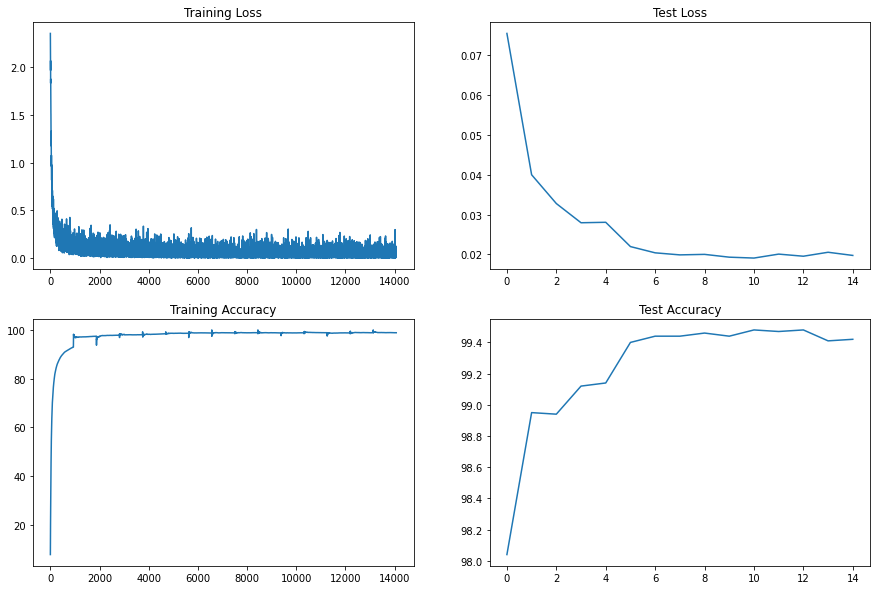

In [25]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")